# A simplified Version of Project Lab2
## from Supplement A: Microwave Radiometer Temperature and Humidity Retrieval

In [6]:
import sys
import traceback
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pn
import xarray as xr
import scipy.stats as stats

import pyOptimalEstimation as pyOE

%matplotlib inline
sns.set(style='ticks', palette='deep')

sys.path.append('lib')
import nonScatMWRadTran
import supporting_routines

In [7]:
def forwardRT(X, pressure=None, zenithAngle=0, frequencies=[]):

    # X contains T and Q, lets split the vector
    temperature, humidity = supporting_routines.splitTQ(X)
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.
    # Height in meters comes from index of the temperature (or humidty) vector
    heights = temperature.index
    assert np.all(np.diff(heights) > 0)

    # get absolute humidty from specific humdity
    abs_humidity = supporting_routines.q2a(humidity, pressure, temperature)
    
    # run the forward operator
    TB, tau, tau_wv, tau_o2 = nonScatMWRadTran.STP_IM10(
        heights,  # [m]  
        temperature,  # [K]
        pressure,  # [Pa]
        abs_humidity,  # [kgm^-3]
        zenithAngle,  # zenith angle of observation in deg.
        frequencies,  # frequency vector in GHz
    )
    return TB

# Load prior dataset
We start with loading the the previously prepared (see [lib/prepare_radiosondes.ipynb](lib/prepare_radiosondes.ipynb)) collection of radiosonde profiles at NSA from 04/2002 to 02/2020. We use the xarray library which provides a transparent interface to netCDF files so that we can directly copy the required variables form the netCDF file. The unit of temperature is Kelvin, specific humidity is provided in g/kg, and pressure is in Pa.


In [8]:
prior = xr.open_dataset('data/radiosonde_climatology_nsa_2002-2020.nc')

prior['q'] = np.log10(prior['q'])

profileTT = np.array([
    '2004-03-16T12:00:00.000000000', '2006-04-01T00:00:00.000000000',
    '2009-01-30T18:00:00.000000000', '2014-07-27T06:00:00.000000000',
    '2018-01-08T12:00:00.000000000'
],dtype='datetime64[ns]')

Yobs_time = '2006-04-01T00:00:00.000000000'

profiles = prior.sel(time=profileTT)
prior = prior.drop_sel(time=profileTT)
nLev = len(prior.height)

priors = {'all': prior}

seasons = [
    'DJF',
    'MAM',
    'JJA',
    'SON',
]

Xa_season = 'MAM'

months = (
    [12, 1, 2],
    [3, 4, 5],
    [6, 7, 8],
    [9, 10, 11],
)
for season, month in zip(seasons, months):
    priors[season] = prior.where(
        np.in1d(prior['time.month'], month)[:, np.newaxis]).dropna(
            'time', how='all')
    
prior_qts = {}
for season in priors.keys():
    prior_q = priors[season]['q'].to_pandas()
    prior_q.columns = ['%05i_q' % (i) for i in prior_q.columns]
    prior_t = priors[season]['temp'].to_pandas()
    prior_t.columns = ['%05i_t' % (i) for i in prior_t.columns]
    prior_qts[season] = pn.concat((prior_q, prior_t), axis=1)
    prior_qts[season] = prior_qts[season].reindex(
        sorted(prior_qts[season].columns), axis=1)

# prior_qts

x_cov = []
x_mean = []

for season in ['all'] + seasons:

    x_cov1 = prior_qts[season].cov().rename_axis('state', axis=0).rename_axis('stateT', axis=1)
    x_mean1 = prior_qts[season].mean().rename_axis('state', axis=0)

    x_cov.append(xr.DataArray(x_cov1))
    x_mean.append(xr.DataArray(x_mean1))

x_cov = xr.concat(x_cov, dim='season')
x_mean = xr.concat(x_mean, dim='season')

x_cov['season'] = ['all'] + seasons
x_mean['season'] = ['all'] + seasons

for season in x_cov.season:
    assert np.linalg.matrix_rank(x_cov.sel(season=season).to_pandas()) ==  x_cov.shape[-1]
    
height = priors['all'].height

pressure = []
for k in ['all'] + seasons:
    pressure.append(priors[k].bar_pres.mean('time'))
pressure = xr.concat(pressure, dim='season')
pressure['season'] = ['all'] + seasons
pressure = pressure.to_pandas()

profiles_t = profiles['temp'].to_pandas()
profiles_t.columns = ['%05i_t' % (i) for i in profiles_t.columns]
profiles_q = profiles['q'].to_pandas()
profiles_q.columns = ['%05i_q' % (i) for i in profiles_q.columns]

x_truths = pn.concat((profiles_t, profiles_q), 1)
x_truths = x_truths.reindex(sorted(x_truths.index), axis=0)
x_truths.columns.name = 'state'
x_truths.index.name = 'time'

assert np.all(np.isfinite(x_truths))

frequencies = [
    22.24, 23.04, 23.84, 25.44, 26.24, 27.84, 31.4, 51.26, 52.28, 53.86, 54.94,
    56.66, 57.3, 58.
]

y_vars = np.array(frequencies)
x_vars = x_mean.state.values

season = Xa_season  #Spring: March April May
profile = np.datetime64(Yobs_time)
x_truth = x_truths.loc[profile]

y_noise = pn.Series(
    [
        0.12026637, 0.10864162, 0.10412012, 0.0918477, 0.10174478, 0.10085633,
        0.10500476, 0.42303663, 0.45658514, 0.26291823, 0.25538793, 0.1773584,
        0.17556195, 0.59489495
    ],
    index=y_vars
)

S_y = pn.DataFrame(
    np.diag(y_noise.values**2),
    index=y_vars,
    columns=y_vars,
)

/tmp/ipykernel_152876/4267379116.py:85: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x_truths = pn.concat((profiles_t, profiles_q), 1)


  File "/tmp/ipykernel_152876/2817321268.py", line 5, in <cell line: 4>
    pyOE.invertMatrix(singularMatrix)


0.69 s, iteration 1, degrees of freedom: 4.70 of 120, not converged (x-space):  938.417
1.02 s, iteration 2, degrees of freedom: 4.67 of 120, not converged (x-space):  23.517
1.36 s, iteration 3, degrees of freedom: 4.67 of 120, converged (x-space):  0.118
1.70 s, iteration 4, degrees of freedom: 4.67 of 120, done.  0.000
RMS X Temperature: 1.79073 [K]
RMS X Humidity: 0.153608 [log$_{10}$(g/kg)]
RMS Y 0.042414 [K]


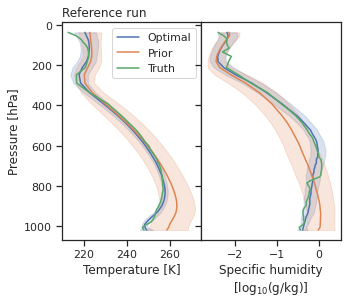

In [9]:
x_a = x_mean.sel(season=Xa_season).to_pandas()[x_vars]
S_a = x_cov.sel(season=Xa_season).to_pandas().loc[x_vars, x_vars]

try:
    pyOE.invertMatrix(singularMatrix)
except Exception as err:
    traceback.print_tb(err.__traceback__)
    
forwardKwArgs = dict(
    pressure=pressure.loc[Xa_season].values,
    zenithAngle=0,
    frequencies=frequencies
)

y_obs = forwardRT(x_truth, **forwardKwArgs)
y_obs = pn.Series(y_obs, index=y_vars)
assert np.all(np.isfinite(y_obs))

oe_ref = pyOE.optimalEstimation(
    x_vars, # state variable names
    x_a,  # a priori
    S_a, # a priori uncertainty
    y_vars,  # measurement variable names
    y_obs, # observations
    S_y, # observation uncertainty
    forwardRT, # forward Operator
    forwardKwArgs=forwardKwArgs, # additonal function arguments
    x_truth=x_truth, # true profile
)

oe_ref.doRetrieval()

fig = supporting_routines.plotMwrResults(
    oe_ref,
    h=pressure.loc[season] / 100,
    hlabel='Pressure [hPa]',
    title='Reference run')

T_optimal, Q_optimal = supporting_routines.splitTQ(oe_ref.x_op)
T_truth, Q_truth = supporting_routines.splitTQ(oe_ref.x_truth)

print('RMS X Temperature: %g [K]'% np.sqrt(np.mean((T_optimal - T_truth)**2)))
print('RMS X Humidity: %g [log$_{10}$(g/kg)]'% np.sqrt(np.mean((10**Q_optimal - 10**Q_truth)**2)))
print('RMS Y %g [K]'% np.sqrt(np.mean((oe_ref.y_obs - oe_ref.y_op)**2)))

Note that we can only estimate the RMS for $\mathbf{x}$, because we used synthetic observations and know $\mathbf{x}_{truth}$

## Modify prior: Using summer instead of spring data 


Here we investigate what happens with the retrieval if an unsuited prior is selected. For this we swap the prior $\mathbf{x}_a$ and **S**$_a$ with data based on summer instead of spring observations

0.68 s, iteration 1, degrees of freedom: 4.57 of 120, not converged (x-space):  11025.582
1.03 s, iteration 2, degrees of freedom: 4.53 of 120, not converged (x-space):  1260.994
1.37 s, iteration 3, degrees of freedom: 4.49 of 120, not converged (x-space):  50.764
1.71 s, iteration 4, degrees of freedom: 4.49 of 120, converged (x-space):  0.635
2.02 s, iteration 5, degrees of freedom: 4.49 of 120, done.  0.002
Reference run:
RMS X Temperature: 1.79073 [K]
RMS X Humidity: 0.153608 [log$_{10}$(g/kg)]
RMS Y 0.042414 [K]
Summer prior:
RMS X Temperature: 5.04336 [K]
RMS X Humidity: 0.37241 [log$_{10}$(g/kg)]
RMS Y 1.08164 [K]


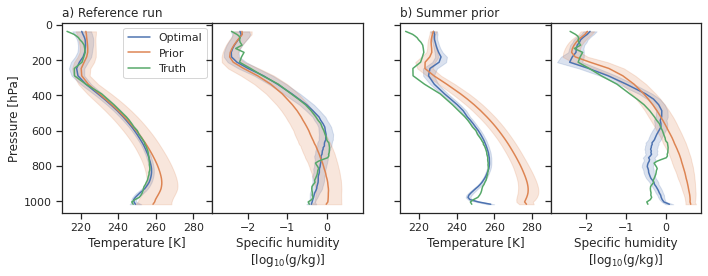

In [10]:
x_a = x_mean.sel(season='JJA').to_pandas()
S_a = x_cov.sel(season='JJA').to_pandas()
forwardKwArgs = dict(
    pressure=pressure.loc['JJA'].values,
    zenithAngle=0,
    frequencies=frequencies
)

oe_sum = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a,
    y_vars,
    y_obs,
    S_y,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_sum.doRetrieval()

fig = supporting_routines.plotMwrResults(
    oe_ref,
    oe2 = oe_sum,
    h=pressure.loc[Xa_season] / 100,
    hlabel='Pressure [hPa]',
    title='a) Reference run',
    title2='b) Summer prior',
    xlimT = (210, 290),
    xlimH = (-2.9,0.9),
)
fig.tight_layout()
fig.savefig('Figure2.png', dpi=200)
fig.savefig('Figure2.pdf')

print('Reference run:')
supporting_routines.print_mwr_rms(oe_ref)
print('Summer prior:')
supporting_routines.print_mwr_rms(oe_sum)